In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from surgeNN.models import build_LSTM_per_variable, build_LSTM_stacked, build_LSTM_stacked_with_attention
from surgeNN.io import load_predictand,load_predictors
from surgeNN.utils import plot_loss_evolution, get_train_test_val_idx, normalize_predictand_splits, normalize_predictor_splits, rmse, create_batched_sequenced_datasets, sequenced_dataset_from_dataset, stack_predictors_for_lstm
from scipy import stats
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

2024-06-06 09:49:25.709267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


from target_relevance import TargetRelevance #first, in terminal, do->'mamba install kdepy'

Load in & preprocess data

In [2]:
#setttings
tg        = 'den_helder-denhdr-nld-rws.csv' #site to predict
temp_freq = 6 #hours
n_steps   = 6 #number of timesteps at and before predictand to use predictors at
n_cells   = 5 #n x n grid cells around TG
batch_size = 128

#predictors
predictors = load_predictors('/home/jovyan/test_surge_models/input/predictors_'+str(temp_freq)+'hourly',tg,n_cells) #open predictor xarray dataset

#predictands
predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_anoms_deseasoned_predictands',tg) #open predictand csv
predictand = predictand.set_index('date').resample(str(temp_freq)+'h').fillna(method=None) #insert nans where timesteps are missing
predictand = predictand.reset_index()[['surge','date','lon','lat']]

predictand['surge'] = predictand['surge'].rolling(window=int(12/temp_freq+1),min_periods=int(12/temp_freq+1),center=True).mean() #crude way to filter out peaks due to uncorrected tides (Tiggeloven et al., 2021)
#predictand = predictand[np.isfinite(predictand['surge'])]#get rid of missing observations (or 12hmeans with missing obs) if any
predictand = predictand[(predictand['date']>=predictors.time.isel(time=0).values) & (predictand['date']<=predictors.time.isel(time=-1).values)]  # only use predictands in the period for which we also have predictor values, including at preceding timesteps
#predictand['surge'] = normalize_timeseries(predictand['surge']) #normalize predictands     

#get split indices (fractions of finite observations)
idx_train_finite,idx_test_finite,idx_val_finite = get_train_test_val_idx(predictand['surge'].values,[.6,.2,.2],shuffle=False) #determine splits (indices) based on available observations

idx_train = range(idx_train_finite[0],idx_train_finite[-1]) #including finite and nan observations
idx_val = range(idx_val_finite[0],idx_val_finite[-1]) #including finite and nan observations
idx_test = range(idx_test_finite[0],idx_test_finite[-1]) #including finite and nan observations

#take predictand splits
y_train = predictand['surge'].values[idx_train]
y_train[0:n_steps-1] = np.nan #predictors not available at t<0
y_val = predictand['surge'].values[idx_val]
y_val[0:n_steps-1] = np.nan #to avoid leakage
y_test = predictand['surge'].values[idx_test]
y_test[0:n_steps-1] = np.nan #to avoid leakage

y_train,y_val,y_test = normalize_predictand_splits(y_train,y_val,y_test)

#take predictor splits
x_train = predictors.sel(time=slice(predictand['date'].values[idx_train[0]],predictand['date'].values[idx_train[-1]]))
x_val  = predictors.sel(time=slice(predictand['date'].values[idx_val[0]],predictand['date'].values[idx_val[-1]]))
x_test  = predictors.sel(time=slice(predictand['date'].values[idx_test[0]],predictand['date'].values[idx_test[-1]]))

x_train,x_val,x_test = normalize_predictor_splits(x_train,x_val,x_test)

def stack_predictors_for_convlstm(predictors,var_names):
    predictors_ = np.stack([predictors[k].values for k in var_names],axis=-1)
    return predictors_#np.reshape(predictors_,(len(predictors.time),len(predictors.latitude) * len(predictors.longitude) * len(var_names)))

x_train = stack_predictors_for_convlstm(x_train,['msl','w','u10','v10']) #stacks & reshapes lon,lat,variable dimensions into one dimension
x_val = stack_predictors_for_convlstm(x_val,['msl','w','u10','v10'])
x_test = stack_predictors_for_convlstm(x_test,['msl','w','u10','v10'])


Generate dataloaders for batches of windowed datasets, ignoring NaN observations:

In [3]:
x_train_ds, y_train_ds = create_batched_sequenced_datasets(x_train, y_train, n_steps, batch_size)
x_val_ds, y_val_ds = create_batched_sequenced_datasets(x_val, y_val, n_steps, batch_size)
x_test_ds, y_test_ds = create_batched_sequenced_datasets(x_test, y_test, n_steps, batch_size)
'''
def create_batched_sequenced_datasets(x,y,n_steps,batch_size):
    xy = np.concatenate((x,np.append(np.nan*np.zeros(n_steps-1),y)[:,np.newaxis]),axis=-1) #not sure yet how to do this generally also for convlstm input?

    xy_tf = tf.data.Dataset.from_tensor_slices(xy).window(n_steps, shift=1, drop_remainder=True)
    xy_windows = xy_tf.flat_map(lambda x: x).batch(n_steps)
    xy_windows = xy_windows.filter(lambda x: tf.reduce_all(tf.math.logical_not(tf.math.is_nan(x)))) #filter out data containing nans (may be present in y)
    x_ds = xy_windows.map(lambda x:x[...,0:-1]).batch(batch_size,drop_remainder=True)
    y_ds = xy_windows.map(lambda x:x[...,-1]).batch(batch_size,drop_remainder=True)
    return x_ds,y_ds

xy_train = np.concatenate((x_train_,np.append(np.nan*np.zeros(n_steps-1),y_train)[:,np.newaxis]),axis=-1) #not sure yet how to do this generally also for convlstm input?

ds = tf.data.Dataset.from_tensor_slices(xy_train).window(6, shift=1, drop_remainder=True)
ds = ds.flat_map(lambda x: x).batch(6)
ds = ds.filter(lambda x: tf.reduce_all(tf.math.logical_not(tf.math.is_nan(x)))) #filter out data containing nans (may be present in y)
x = ds.map(lambda x:x[...,0:-1]).batch(128,drop_remainder=True)
y = ds.map(lambda x:x[...,-1]).batch(128,drop_remainder=True)

#this way, y_train should include nans where there are no observations
'''

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


'\ndef create_batched_sequenced_datasets(x,y,n_steps,batch_size):\n    xy = np.concatenate((x,np.append(np.nan*np.zeros(n_steps-1),y)[:,np.newaxis]),axis=-1) #not sure yet how to do this generally also for convlstm input?\n\n    xy_tf = tf.data.Dataset.from_tensor_slices(xy).window(n_steps, shift=1, drop_remainder=True)\n    xy_windows = xy_tf.flat_map(lambda x: x).batch(n_steps)\n    xy_windows = xy_windows.filter(lambda x: tf.reduce_all(tf.math.logical_not(tf.math.is_nan(x)))) #filter out data containing nans (may be present in y)\n    x_ds = xy_windows.map(lambda x:x[...,0:-1]).batch(batch_size,drop_remainder=True)\n    y_ds = xy_windows.map(lambda x:x[...,-1]).batch(batch_size,drop_remainder=True)\n    return x_ds,y_ds\n\nxy_train = np.concatenate((x_train_,np.append(np.nan*np.zeros(n_steps-1),y_train)[:,np.newaxis]),axis=-1) #not sure yet how to do this generally also for convlstm input?\n\nds = tf.data.Dataset.from_tensor_slices(xy_train).window(6, shift=1, drop_remainder=True)\n

In [7]:
x_train.shape

(31556, 20, 20, 4)

In [6]:
next(iter(y_train_ds))

<tf.Tensor: shape=(128, 20, 20), dtype=float64, numpy=
array([[[1.15291492, 1.15291492, 1.15291492, ..., 1.15291492,
         1.15291492, 1.15291492],
        [1.15291492, 1.15291492, 1.15291492, ..., 1.15291492,
         1.15291492, 1.15291492],
        [1.15291492, 1.15291492, 1.15291492, ..., 1.15291492,
         1.15291492, 1.15291492],
        ...,
        [1.15291492, 1.15291492, 1.15291492, ..., 1.15291492,
         1.15291492, 1.15291492],
        [1.15291492, 1.15291492, 1.15291492, ..., 1.15291492,
         1.15291492, 1.15291492],
        [1.15291492, 1.15291492, 1.15291492, ..., 1.15291492,
         1.15291492, 1.15291492]],

       [[0.61397975, 0.61397975, 0.61397975, ..., 0.61397975,
         0.61397975, 0.61397975],
        [0.61397975, 0.61397975, 0.61397975, ..., 0.61397975,
         0.61397975, 0.61397975],
        [0.61397975, 0.61397975, 0.61397975, ..., 0.61397975,
         0.61397975, 0.61397975],
        ...,
        [0.61397975, 0.61397975, 0.61397975, ..., 0.6

In [ ]:
x_train

Create parameter space:

In [3]:

n_steps = np.arange(4,10,2).astype('int')
batch_size = np.array([128]).astype('int')
alpha = np.arange(0.5,5.5,0.5)
n_lstm = np.array([1,2]).astype('int')
n_dense = np.array([2,3]).astype('int')
n_units = np.array([24,48]).astype('int')
dropout = np.array([0.1,0.2])
lrs = np.array([1e-4,5e-4,1e-5,5e-5, 1e-6])
l1s = np.array([0.01,0.02])
'''
n_steps = np.arange(8,14,2).astype('int')
batch_size = np.array([64,128]).astype('int')
alpha = np.arange(3.5,6,0.5)
n_lstm = np.array([1,2]).astype('int')
n_dense = np.array([1,2]).astype('int')
n_units = np.array([24,48]).astype('int')
dropout = np.array([0.1,0.2])
lrs = np.array([1e-5,3e-5,5e-5])
l1s = np.array([0.02])
'''
possible_settings = [n_steps,batch_size,alpha,n_lstm,n_dense,n_units,dropout,lrs,l1s]


In [4]:
settings = []
rs = []
rmses = []
fps = []
fns = []
tps = []
tns = []
for i in tqdm(np.arange(100)):
    i_settings = [np.random.choice(k) for k in possible_settings]
    settings.append(i_settings)
    
    n_steps = i_settings[0]
    batch_size = i_settings[1]
    
    #generate loss weights:
    target_relevance = TargetRelevance(surge_obs[np.append(idx_train,idx_val)], alpha=i_settings[2])
    weights = target_relevance.eval(surge_obs[np.append(idx_train,idx_val)]).flatten()
    
    #generate input datasets:
    xx_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_train,...]), n_steps, batch_size)
    yy_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(surge_obs[idx_train][n_steps-1::]), 1, batch_size)
    ww_train = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(weights[idx_train][n_steps-1::]), 1, batch_size) #test
    zz_train = tf.data.Dataset.zip((xx_train,yy_train,ww_train))

    xx_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_val,...]), n_steps, batch_size)
    yy_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(surge_obs[idx_val][n_steps-1::]), 1, batch_size)
    ww_val = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(weights[idx_val][n_steps-1::]), 1, batch_size) #test
    zz_val = tf.data.Dataset.zip((xx_val,yy_val,ww_val))
    
    xx_test = sequenced_dataset_from_dataset(tf.data.Dataset.from_tensor_slices(my_predictors[idx_test,...]), n_steps, batch_size)

    #build model:
    model = build_LSTM_stacked(i_settings[3], i_settings[4], 
                              (np.ones(i_settings[3])*i_settings[5]).astype(int), 
                              (np.ones(i_settings[4])*i_settings[5]).astype(int), n_steps,20,20,4, 'model0',
                               i_settings[6], i_settings[7], 'mae',l2=i_settings[8])
    
    #train model:
    history = model.fit(zz_train,epochs=100,validation_data=zz_val,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                        restore_best_weights=True)],verbose=0)
    
    
    
    #infer test set and evaluate extremes
    surge_cnn_test = model.predict(xx_test,verbose=0).flatten()
   
    threshold_pct = 98 #percentile of storm surge data to look at

    surge_obs_test = surge_obs[idx_test][n_steps-1::] #surge_obs[idx_test]
    threshold_value = np.percentile(surge_obs[idx_test][n_steps-1::],threshold_pct) #threshold value

    surge_obs_test_exceedances = (surge_obs[idx_test][n_steps-1::]>=threshold_value).flatten() #find where storm surges exceed threshold (extremes), for observations
    surge_cnn_test_exceedances = (surge_cnn_test>=threshold_value).flatten() #find where storm surges exceed threshold (extremes), for predictions with CNN

    rs.append(np.corrcoef(surge_cnn_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances])[0][1])
    rmses.append(rmse(surge_cnn_test[surge_obs_test_exceedances],surge_obs_test[surge_obs_test_exceedances]))

    cmat = confusion_matrix(surge_obs_test_exceedances,surge_cnn_test_exceedances)
    tns.append(cmat[0,0])
    fns.append(cmat[1,0])
    fps.append(cmat[0,1])
    tps.append(cmat[1,1])


  0%|          | 0/200 [00:00<?, ?it/s]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


  0%|          | 1/200 [01:48<6:00:24, 108.66s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


  1%|          | 2/200 [03:39<6:02:34, 109.87s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


  2%|▏         | 3/200 [04:00<3:47:40, 69.34s/it] 

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


  2%|▏         | 4/200 [04:57<3:30:02, 64.30s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


  2%|▎         | 5/200 [05:50<3:16:05, 60.34s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


  3%|▎         | 6/200 [09:26<6:06:28, 113.34s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


  4%|▎         | 7/200 [13:57<8:50:17, 164.86s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


  4%|▍         | 8/200 [16:54<8:59:56, 168.73s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


  4%|▍         | 9/200 [20:57<10:11:26, 192.08s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


  5%|▌         | 10/200 [21:59<8:00:54, 151.86s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


  6%|▌         | 11/200 [22:30<6:01:25, 114.74s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


  6%|▌         | 12/200 [23:24<5:01:24, 96.19s/it] 

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


  6%|▋         | 13/200 [24:01<4:04:28, 78.44s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


  7%|▋         | 14/200 [24:29<3:15:19, 63.01s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


  8%|▊         | 15/200 [25:52<3:32:52, 69.04s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


  8%|▊         | 16/200 [26:50<3:21:31, 65.71s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


  8%|▊         | 17/200 [28:31<3:52:53, 76.36s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


  9%|▉         | 18/200 [29:40<3:45:17, 74.27s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 10%|▉         | 19/200 [30:12<3:05:23, 61.46s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 10%|█         | 20/200 [34:12<5:45:18, 115.10s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 10%|█         | 21/200 [38:15<7:38:29, 153.68s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 11%|█         | 22/200 [43:59<10:25:21, 210.79s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 12%|█▏        | 23/200 [44:46<7:56:52, 161.65s/it] 

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 12%|█▏        | 24/200 [49:21<9:33:45, 195.60s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 12%|█▎        | 25/200 [51:44<8:44:15, 179.75s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 13%|█▎        | 26/200 [54:37<8:35:17, 177.69s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 14%|█▎        | 27/200 [55:29<6:44:05, 140.15s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 14%|█▍        | 28/200 [56:10<5:16:06, 110.27s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 14%|█▍        | 29/200 [57:06<4:28:01, 94.04s/it] 

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 15%|█▌        | 30/200 [58:25<4:13:49, 89.59s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 16%|█▌        | 31/200 [59:37<3:57:17, 84.24s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 16%|█▌        | 32/200 [1:01:31<4:20:30, 93.04s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 16%|█▋        | 33/200 [1:05:50<6:37:55, 142.97s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 17%|█▋        | 34/200 [1:07:06<5:39:56, 122.87s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 18%|█▊        | 35/200 [1:08:33<5:08:00, 112.00s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 18%|█▊        | 36/200 [1:13:38<7:44:12, 169.83s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 18%|█▊        | 37/200 [1:17:26<8:29:12, 187.44s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 19%|█▉        | 38/200 [1:20:24<8:18:00, 184.45s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 20%|█▉        | 39/200 [1:20:59<6:15:14, 139.84s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 20%|██        | 40/200 [1:22:20<5:25:42, 122.14s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 20%|██        | 41/200 [1:24:01<5:06:28, 115.65s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 21%|██        | 42/200 [1:24:54<4:15:15, 96.94s/it] 

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 22%|██▏       | 43/200 [1:30:53<7:39:32, 175.62s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 22%|██▏       | 44/200 [1:31:38<5:54:17, 136.27s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 22%|██▎       | 45/200 [1:32:43<4:56:52, 114.92s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 23%|██▎       | 46/200 [1:33:28<4:01:32, 94.11s/it] 

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 24%|██▎       | 47/200 [1:34:43<3:44:53, 88.19s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 24%|██▍       | 48/200 [1:35:31<3:13:25, 76.35s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 24%|██▍       | 49/200 [1:36:08<2:41:57, 64.35s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 25%|██▌       | 50/200 [1:36:41<2:17:29, 54.99s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 26%|██▌       | 51/200 [1:39:45<3:52:45, 93.73s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 26%|██▌       | 52/200 [1:41:42<4:08:17, 100.66s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 26%|██▋       | 53/200 [1:44:32<4:57:21, 121.37s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 27%|██▋       | 54/200 [1:47:42<5:45:55, 142.16s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 28%|██▊       | 55/200 [1:51:39<6:52:16, 170.60s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 28%|██▊       | 56/200 [1:52:22<5:17:04, 132.12s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 28%|██▊       | 57/200 [1:52:39<3:53:03, 97.79s/it] 

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 29%|██▉       | 58/200 [1:53:36<3:22:08, 85.41s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 30%|██▉       | 59/200 [1:54:17<2:49:43, 72.22s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 30%|███       | 60/200 [1:55:48<3:01:23, 77.74s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 30%|███       | 61/200 [1:56:34<2:38:27, 68.40s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 31%|███       | 62/200 [1:56:51<2:01:37, 52.88s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 32%|███▏      | 63/200 [1:57:38<1:56:27, 51.00s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 32%|███▏      | 64/200 [1:58:15<1:46:17, 46.90s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 32%|███▎      | 65/200 [1:58:51<1:38:06, 43.60s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 33%|███▎      | 66/200 [2:00:40<2:21:07, 63.19s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 34%|███▎      | 67/200 [2:01:39<2:17:27, 62.01s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 34%|███▍      | 68/200 [2:02:00<1:49:02, 49.56s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 34%|███▍      | 69/200 [2:03:03<1:57:29, 53.81s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 35%|███▌      | 70/200 [2:04:41<2:25:21, 67.09s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 36%|███▌      | 71/200 [2:05:14<2:02:05, 56.78s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 36%|███▌      | 72/200 [2:07:47<3:02:24, 85.50s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 36%|███▋      | 73/200 [2:09:20<3:05:42, 87.73s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 37%|███▋      | 74/200 [2:10:44<3:02:04, 86.70s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 38%|███▊      | 75/200 [2:11:27<2:33:24, 73.63s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 38%|███▊      | 76/200 [2:13:59<3:21:02, 97.27s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 38%|███▊      | 77/200 [2:14:38<2:43:26, 79.72s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 39%|███▉      | 78/200 [2:19:58<5:08:14, 151.59s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 40%|███▉      | 79/200 [2:20:33<3:55:33, 116.80s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 40%|████      | 80/200 [2:23:13<4:19:34, 129.79s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 40%|████      | 81/200 [2:23:43<3:17:56, 99.80s/it] 

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 42%|████▏     | 84/200 [2:27:10<2:33:25, 79.36s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 42%|████▎     | 85/200 [2:28:08<2:19:58, 73.03s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 43%|████▎     | 86/200 [2:29:08<2:11:38, 69.28s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 44%|████▎     | 87/200 [2:30:08<2:05:10, 66.47s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 44%|████▍     | 88/200 [2:30:47<1:48:26, 58.09s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 44%|████▍     | 89/200 [2:31:33<1:40:49, 54.50s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 45%|████▌     | 90/200 [2:32:18<1:34:47, 51.71s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 46%|████▌     | 91/200 [2:32:53<1:24:53, 46.73s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 46%|████▌     | 92/200 [2:35:05<2:09:59, 72.22s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 46%|████▋     | 93/200 [2:35:48<1:53:11, 63.47s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 47%|████▋     | 94/200 [2:36:40<1:45:53, 59.94s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 48%|████▊     | 95/200 [2:38:30<2:11:20, 75.06s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 48%|████▊     | 96/200 [2:39:14<1:53:51, 65.69s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 48%|████▊     | 97/200 [2:40:35<2:00:50, 70.40s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 49%|████▉     | 98/200 [2:43:30<2:53:08, 101.85s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 50%|████▉     | 99/200 [2:44:23<2:26:28, 87.02s/it] 

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 50%|█████     | 100/200 [2:49:17<4:08:23, 149.03s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 50%|█████     | 101/200 [2:49:59<3:13:21, 117.18s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 51%|█████     | 102/200 [2:51:25<2:56:03, 107.80s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 52%|█████▏    | 103/200 [2:56:15<4:22:14, 162.21s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 52%|█████▏    | 104/200 [2:56:52<3:19:36, 124.76s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 52%|█████▎    | 105/200 [2:57:28<2:35:25, 98.17s/it] 

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 53%|█████▎    | 106/200 [3:03:20<4:32:51, 174.16s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 54%|█████▎    | 107/200 [3:06:19<4:32:35, 175.87s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 54%|█████▍    | 108/200 [3:07:21<3:36:57, 141.50s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 55%|█████▍    | 109/200 [3:08:18<2:56:27, 116.34s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 55%|█████▌    | 110/200 [3:09:56<2:46:17, 110.86s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 56%|█████▌    | 111/200 [3:10:37<2:12:58, 89.65s/it] 

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 56%|█████▌    | 112/200 [3:11:47<2:02:58, 83.85s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 56%|█████▋    | 113/200 [3:13:51<2:18:59, 95.85s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 57%|█████▋    | 114/200 [3:15:12<2:10:59, 91.39s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 57%|█████▊    | 115/200 [3:15:55<1:48:53, 76.87s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 58%|█████▊    | 116/200 [3:16:46<1:36:41, 69.06s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 58%|█████▊    | 117/200 [3:17:47<1:32:34, 66.93s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 59%|█████▉    | 118/200 [3:18:38<1:24:39, 61.94s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 60%|█████▉    | 119/200 [3:20:05<1:33:55, 69.57s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 60%|██████    | 120/200 [3:22:19<1:58:29, 88.87s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 60%|██████    | 121/200 [3:23:07<1:40:50, 76.59s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 61%|██████    | 122/200 [3:23:39<1:22:15, 63.27s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 62%|██████▏   | 123/200 [3:24:25<1:14:26, 58.01s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 62%|██████▏   | 124/200 [3:25:40<1:19:46, 62.98s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 62%|██████▎   | 125/200 [3:26:18<1:09:40, 55.74s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 63%|██████▎   | 126/200 [3:27:59<1:25:20, 69.20s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 64%|██████▎   | 127/200 [3:33:07<2:51:16, 140.78s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 64%|██████▍   | 128/200 [3:37:00<3:22:06, 168.42s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 64%|██████▍   | 129/200 [3:38:49<2:58:27, 150.81s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 65%|██████▌   | 130/200 [3:39:43<2:22:02, 121.75s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 66%|██████▌   | 131/200 [3:40:36<1:56:10, 101.02s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 66%|██████▌   | 132/200 [3:44:24<2:37:38, 139.10s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 66%|██████▋   | 133/200 [3:45:14<2:05:31, 112.41s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 67%|██████▋   | 134/200 [3:45:55<1:39:58, 90.89s/it] 

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 68%|██████▊   | 135/200 [3:46:38<1:22:52, 76.50s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 68%|██████▊   | 136/200 [3:49:45<1:57:11, 109.86s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 68%|██████▊   | 137/200 [3:50:11<1:28:55, 84.69s/it] 

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 69%|██████▉   | 138/200 [3:50:49<1:12:53, 70.54s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 70%|██████▉   | 139/200 [3:51:35<1:04:19, 63.27s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 70%|███████   | 140/200 [3:53:00<1:09:49, 69.82s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 70%|███████   | 141/200 [3:54:14<1:09:54, 71.09s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 71%|███████   | 142/200 [3:54:57<1:00:34, 62.66s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 72%|███████▏  | 143/200 [3:57:26<1:24:00, 88.44s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 72%|███████▏  | 144/200 [3:58:47<1:20:32, 86.30s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 72%|███████▎  | 145/200 [4:01:17<1:36:38, 105.42s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 73%|███████▎  | 146/200 [4:01:43<1:13:29, 81.66s/it] 

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 74%|███████▎  | 147/200 [4:02:17<59:30, 67.37s/it]  

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 74%|███████▍  | 148/200 [4:04:45<1:19:08, 91.31s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 74%|███████▍  | 149/200 [4:05:53<1:11:44, 84.40s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 75%|███████▌  | 150/200 [4:08:27<1:27:43, 105.28s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 76%|███████▌  | 151/200 [4:13:31<2:14:34, 164.78s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 76%|███████▌  | 152/200 [4:14:06<1:40:49, 126.03s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 76%|███████▋  | 153/200 [4:15:23<1:27:10, 111.28s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 77%|███████▋  | 154/200 [4:17:44<1:32:14, 120.32s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 78%|███████▊  | 155/200 [4:21:34<1:54:46, 153.02s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 78%|███████▊  | 156/200 [4:25:04<2:04:44, 170.11s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 78%|███████▊  | 157/200 [4:27:32<1:57:18, 163.69s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 79%|███████▉  | 158/200 [4:27:59<1:25:46, 122.53s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 80%|███████▉  | 159/200 [4:28:41<1:07:08, 98.25s/it] 

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 80%|████████  | 160/200 [4:29:54<1:00:34, 90.85s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 80%|████████  | 161/200 [4:30:48<51:52, 79.80s/it]  

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 81%|████████  | 162/200 [4:31:33<43:49, 69.20s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 82%|████████▏ | 163/200 [4:32:36<41:37, 67.50s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 82%|████████▏ | 164/200 [4:33:15<35:15, 58.78s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 82%|████████▎ | 165/200 [4:36:04<53:36, 91.89s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 83%|████████▎ | 166/200 [4:37:40<52:53, 93.32s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 84%|████████▎ | 167/200 [4:39:02<49:23, 89.79s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 84%|████████▍ | 168/200 [4:40:37<48:44, 91.40s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 84%|████████▍ | 169/200 [4:41:33<41:46, 80.86s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 85%|████████▌ | 170/200 [4:42:35<37:28, 74.95s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 86%|████████▌ | 171/200 [4:43:45<35:37, 73.69s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 86%|████████▌ | 172/200 [4:45:17<36:53, 79.07s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 86%|████████▋ | 173/200 [4:46:05<31:27, 69.92s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 87%|████████▋ | 174/200 [4:48:07<37:00, 85.41s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 88%|████████▊ | 175/200 [4:49:50<37:46, 90.65s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 88%|████████▊ | 176/200 [4:51:22<36:29, 91.21s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


 88%|████████▊ | 177/200 [4:52:48<34:17, 89.44s/it]

TargetRelevance alpha: 1.0
Using Silverman Bandwidth 0.12847424667144736


 89%|████████▉ | 178/200 [4:54:01<31:03, 84.69s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 90%|████████▉ | 179/200 [4:54:42<24:59, 71.41s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 90%|█████████ | 180/200 [4:57:24<32:52, 98.63s/it]

TargetRelevance alpha: 2.0
Using Silverman Bandwidth 0.12847424667144736


 90%|█████████ | 181/200 [4:58:03<25:31, 80.62s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 91%|█████████ | 182/200 [5:00:48<31:46, 105.94s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 92%|█████████▏| 183/200 [5:04:28<39:46, 140.41s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 92%|█████████▏| 184/200 [5:06:01<33:36, 126.02s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


 92%|█████████▎| 185/200 [5:06:57<26:17, 105.19s/it]

TargetRelevance alpha: 3.0
Using Silverman Bandwidth 0.12847424667144736


 93%|█████████▎| 186/200 [5:07:50<20:51, 89.40s/it] 

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 94%|█████████▎| 187/200 [5:08:31<16:12, 74.80s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 94%|█████████▍| 188/200 [5:09:12<12:56, 64.73s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 94%|█████████▍| 189/200 [5:12:03<17:41, 96.49s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 95%|█████████▌| 190/200 [5:12:54<13:49, 82.99s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 96%|█████████▌| 191/200 [5:13:37<10:39, 71.01s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 96%|█████████▌| 192/200 [5:14:38<09:04, 68.11s/it]

TargetRelevance alpha: 4.5
Using Silverman Bandwidth 0.12847424667144736


 96%|█████████▋| 193/200 [5:15:02<06:22, 54.70s/it]

TargetRelevance alpha: 0.5
Using Silverman Bandwidth 0.12847424667144736


 97%|█████████▋| 194/200 [5:16:27<06:23, 63.88s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 98%|█████████▊| 195/200 [5:17:22<05:06, 61.22s/it]

TargetRelevance alpha: 3.5
Using Silverman Bandwidth 0.12847424667144736


 98%|█████████▊| 196/200 [5:18:00<03:37, 54.26s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 98%|█████████▊| 197/200 [5:18:27<02:17, 45.96s/it]

TargetRelevance alpha: 1.5
Using Silverman Bandwidth 0.12847424667144736


 99%|█████████▉| 198/200 [5:19:34<01:44, 52.30s/it]

TargetRelevance alpha: 2.5
Using Silverman Bandwidth 0.12847424667144736


100%|█████████▉| 199/200 [5:20:15<00:49, 49.04s/it]

TargetRelevance alpha: 4.0
Using Silverman Bandwidth 0.12847424667144736


100%|██████████| 200/200 [5:21:28<00:00, 96.44s/it]


In [5]:
ds = xr.Dataset(
    data_vars=dict(
        corr=(["i"], rs),
        rmse=(["i"], rmses),
        tps=(["i"], tps),
        tns=(["i"], tns),
        fps=(["i"], fps),
        fns=(["i"], fns),
    ),
    coords=dict(
        settings=(["i",'setting'], np.array(settings)),
    ),
)
ds['setting'] = ['n_steps','batch_size','alpha','n_lstm','n_dense','n_units','dropout','lrs','l1s']
ds.to_netcdf('lstm_tuning_output_6h.nc',mode='w')

In [12]:
i_settings

[2, 64, 1.0, 1, 3, 24, 0.1, 5e-05, 0.01]

In [2]:
ds = xr.open_dataset('lstm_tuning_output_6h.nc')

In [14]:
ds.settings[0]

<xarray.DataArray 'settings' ()>
array('n_steps', dtype='<U7')
Coordinates:
    settings  <U7 'n_steps'

TargetRelevance alpha: 1
Using Silverman Bandwidth 0.12847424667144736
TargetRelevance alpha: 2
Using Silverman Bandwidth 0.12847424667144736
TargetRelevance alpha: 3
Using Silverman Bandwidth 0.12847424667144736


Text(0.5, 0, 'Surge height [st. dev.]')

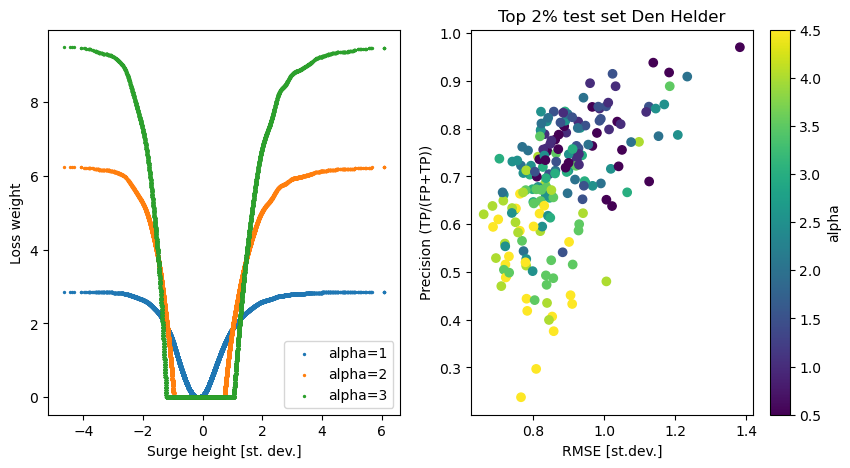

In [58]:
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1,2)
gs.update(wspace=.2)
ax = plt.subplot(gs[0,1])

s = ax.scatter(ds.rmse,ds.tps/(ds.fps+ds.tps),c=ds.settings.sel(setting='alpha'))
plt.colorbar(s, ax=ax,orientation='vertical',label='alpha')
ax.set_xlabel('RMSE [st.dev.]')
ax.set_ylabel('Precision (TP/(FP+TP))')
ax.set_title('Top 2% test set Den Helder')

ax = plt.subplot(gs[0,0])

for a in np.array([1,2,3]):
    target_relevance = TargetRelevance(surge_obs[np.append(idx_train,idx_val)], alpha=a)
    weights = target_relevance.eval(surge_obs[np.append(idx_train,idx_val)]).flatten()
    ax.scatter(surge_obs[np.append(idx_train,idx_val)],weights,s=2,label='alpha='+str(a))
ax.set_ylabel('Loss weight')
ax.legend()
ax.set_xlabel('Surge height [st. dev.]')
#ax.set_colorbar(s, orientation='vertical',label='alpha')





In [26]:
target_relevance = TargetRelevance(surge_obs[np.append(idx_train,idx_val)], alpha=1)
weights = target_relevance.eval(surge_obs[np.append(idx_train,idx_val)]).flatten()

TargetRelevance alpha: 1
Using Silverman Bandwidth 0.12847424667144736


Text(0.5, 1.0, 'DenseLoss (KDE)')

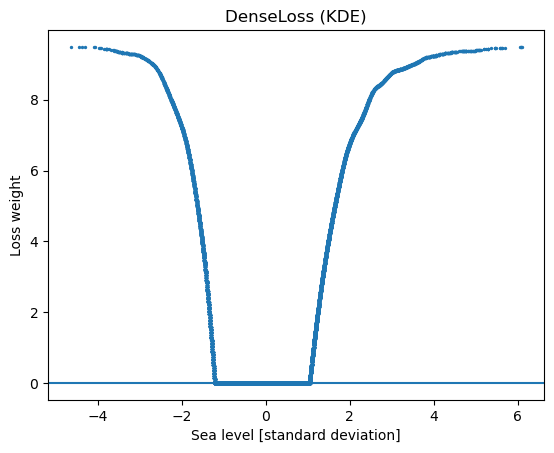

In [44]:
plt.figure()
plt.scatter(surge_obs[np.append(idx_train,idx_val)],weights,s=2)
plt.axhline(y=0)
plt.ylabel('Loss weight')
plt.xlabel('Sea level [standard deviation]')
plt.title('DenseLoss (KDE)')